#### Final Project: Rick & Morty analysis

# Phase 1: Generate data inputs

**"I don't do magic Morty, I do science. One takes brain, the other takes dark eyeliner" - Pickle Rick, S03E03**

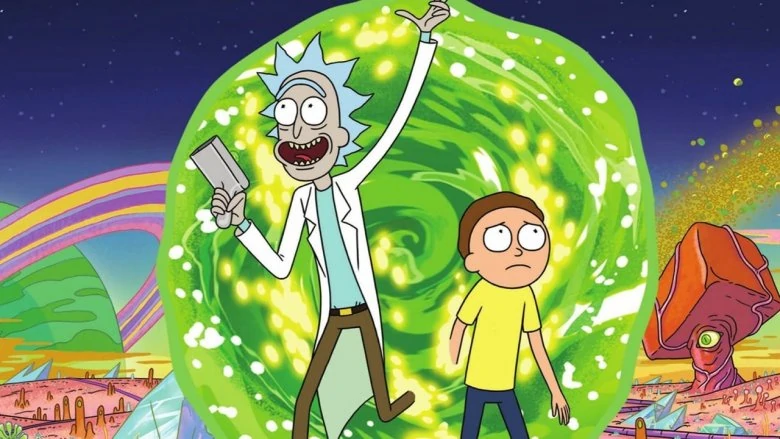

In [182]:
# IMPORT
import urllib.request
import json
import re
import html_to_json
import pandas as pd
import codecs

## Get the list of characters, and associated fandom hyperlinks

`<a href="/wiki/Birdperson%27s_Daughter" class="category-page__member-link" title="Birdperson&#039;s Daughter">Birdperson&#039;s Daughter</a>`


In [166]:
# Get the list of characters

characters_dict = {}

base_url = "https://rickandmorty.fandom.com"

# we enters the three list of characters Wiki pages manually
characters_wiki_pages = [
    "/wiki/Category:Characters",
    "/wiki/Category:Characters?from=Greebybobes",
    "/wiki/Category:Characters?from=Regular+Legs"
]

# to be sure that we have the correct count of items in the end
isCategoryCount = 0

for aCharactersWikiPage in characters_wiki_pages:
    wikiresponse = urllib.request.urlopen(base_url+aCharactersWikiPage)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikidict = html_to_json.convert(wikitext)
    # get the "mw_parser_output" HTML element
    mw_parser_output = wikidict['html'][0]['body'][0]['div'][3]['div'][2]['div'][1]['main'][0]['div'][2]['div'][0]['div']
    # find the "category-page__members" HTML div element
    category_page_members = None
    for element in mw_parser_output:
        if element['_attributes']['class'] == ['category-page__members']:
            category_page_members = element['div']
    # find the list of characters
    for i in range (len(category_page_members)):
        list_to_read = category_page_members[i]['ul'][0]['li']
        # read each item of the list of characters
        for j in range (len(list_to_read)):
            attributes_ij = list_to_read[j]['a'][0]['_attributes']
            href_ij, title_ij = attributes_ij['href'], attributes_ij['title']
            # be sure title == value if list item
            assert list_to_read[j]['a'][0]['_value'] == title_ij
            # store character's name (title_ij) and its hyperlink (href_ij)
            if 'Category:' not in title_ij:
                characters_dict[title_ij] = base_url+href_ij
            else:
                isCategoryCount +=1

Let's check that we have the correct number of nodes:
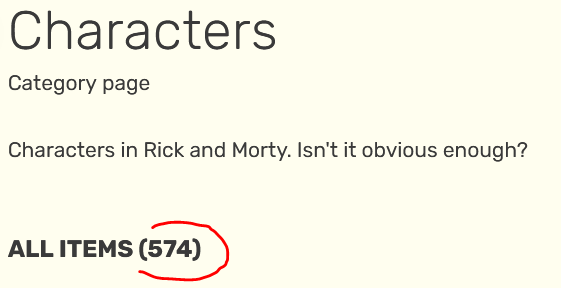

In [171]:
print(f"We read {len(characters_dict)+isCategoryCount} elements, whose {len(characters_dict)} are actual characters.")

We read 574 elements, whose 547 are actual characters.


In [172]:
# Manually remove "Evil_Morty/Theories" who appears in Characters but it's not!
characters_dict.pop('Evil Morty/Theories')

'https://rickandmorty.fandom.com/wiki/Evil_Morty/Theories'

In [174]:
# Generate DataFrame (Pandas)
df_characters = pd.DataFrame({'Name':list(characters_dict.keys()),'Hyperlink':list(characters_dict.values())})

In [175]:
# Be sure there is no duplicates
assert len(df_characters) == len(df_characters.drop_duplicates(subset='Name', keep='last'))

In [178]:
# Save as a csv
# df_characters.to_csv('RaM_characters.csv', index=False)

In [179]:
df_characters.head()

,Name,Hyperlink
0,Abandoned Jerrys,https://rickandmorty.fandom.com/wiki/Abandoned...
1,Abrodolph Lincoler,https://rickandmorty.fandom.com/wiki/Abrodolph...
2,Adam,https://rickandmorty.fandom.com/wiki/Adam
3,Adjudicator Rick,https://rickandmorty.fandom.com/wiki/Adjudicat...
4,Afro Rick,https://rickandmorty.fandom.com/wiki/Afro_Rick


## Get the list of all episodes
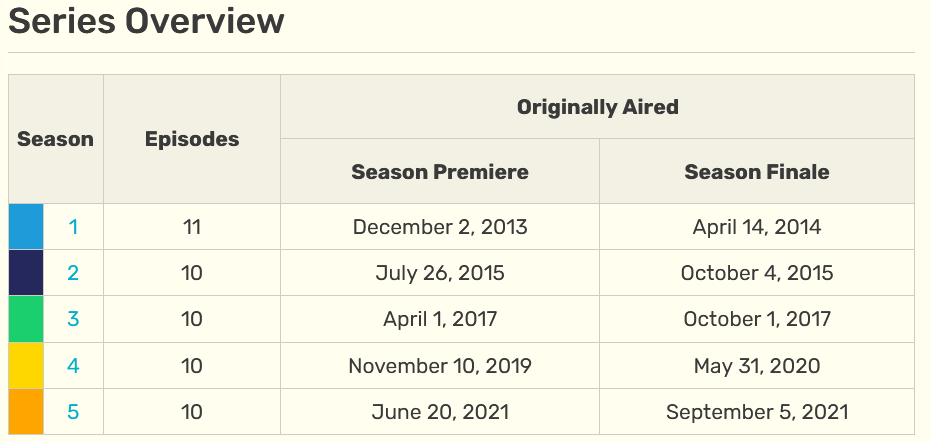

In [8]:
def getHTMLwithAttribute(attributeValue, HTMLtype, attributeName, aList):
    for element in aList:
        if "_attributes" in element.keys() and attributeName in element["_attributes"].keys() and attributeValue in element["_attributes"][attributeName] and HTMLtype in element.keys():
            return element[HTMLtype]
    return None

def getHTMLwithClass(className, HTMLtype, aList):
    return getHTMLwithAttribute(className, HTMLtype, 'class', aList)

def getHTMLwithId(idName, HTMLtype, aList):
    return getHTMLwithAttribute(idName, HTMLtype, 'id', aList)

def getHTMLDivWithClass(className, aList):
    return getHTMLwithClass(className, 'div', aList)

def getHTMLDivWithId(idName, aList):
    return getHTMLwithId(idName, 'div', aList)

In [9]:
episodes_dict = {}

for aSeasonNb in list(range(1,6)):
    aSeasonWikiPage = "/wiki/Season_"+str(aSeasonNb)

    wikiresponse = urllib.request.urlopen(base_url+aSeasonWikiPage)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikidict = html_to_json.convert(wikitext)

    main_container = getHTMLDivWithClass('main-container', wikidict['html'][0]['body'][0]['div'])
    resizable_container = getHTMLDivWithClass('resizable-container', main_container)
    page_has_right_rail = getHTMLwithClass('has-right-rail', 'main', resizable_container)
    page_main = getHTMLDivWithClass('page__main', page_has_right_rail)
    content = getHTMLDivWithId('content', page_main)
    mw_content_text = getHTMLDivWithId('mw-content-text',content)
    episodes_table = getHTMLwithClass('mw-parser-output', 'table', mw_content_text)[0]['tbody'][0]['tr']

    episodeNb = 1
    for anEpisodeElement in episodes_table:
        if 'td' in anEpisodeElement.keys():
            td_element = anEpisodeElement['td']
            b_element = getHTMLwithAttribute('text-align:left;', 'b', 'style', td_element)
            if b_element != None:
                # get dictionary inside
                b_element = b_element[0]['a'][0]['_attributes']
                episode_href, episode_title = b_element['href'], b_element['title']
                episodes_dict[episode_title] = {'href':episode_href, 'seasonNb':aSeasonNb, 'episodeNb':episodeNb}
                episodeNb += 1

In [10]:
print(f"We found {len(episodes_dict.keys())} episodes.")

We found 50 episodes.


In [11]:
# Generate DataFrame (Pandas)
df_episodes = pd.DataFrame({
    'Title':list(episodes_dict.keys()),
    'Hyperlink':[base_url+element['href'] for element in episodes_dict.values()],
    'Season_nb':[element['seasonNb'] for element in episodes_dict.values()],
    'Episode_nb':[element['episodeNb'] for element in episodes_dict.values()],
})

In [12]:
# Be sure there is no duplicates
assert len(df_episodes) == len(df_episodes.drop_duplicates(subset='Title', keep='last'))

In [13]:
# Save as a csv
# df_episodes.to_csv('RaM_episodes.csv', index=False)

In [14]:
df_episodes.head()

,Title,Hyperlink,Season_nb,Episode_nb
0,Pilot,https://rickandmorty.fandom.com/wiki/Pilot,1,1
1,Lawnmower Dog,https://rickandmorty.fandom.com/wiki/Lawnmower...,1,2
2,Anatomy Park (Episode),https://rickandmorty.fandom.com/wiki/Anatomy_P...,1,3
3,M. Night Shaym-Aliens!,https://rickandmorty.fandom.com/wiki/M._Night_...,1,4
4,Meeseeks and Destroy,https://rickandmorty.fandom.com/wiki/Meeseeks_...,1,5


## Get the source code of each episode and each character

In [180]:
def getSourceCode(aLink):
    aLink += "?action=edit"
    wikiresponse = urllib.request.urlopen(aLink)
    wikitext = wikiresponse.read().decode('utf-8')
    wikidict = html_to_json.convert(wikitext)
    
    wikidict = getHTMLDivWithClass('main-container', wikidict['html'][0]['body'][0]['div'])
    wikidict = getHTMLDivWithClass('resizable-container', wikidict)
    wikidict = getHTMLwithClass('page-is-edit','main',wikidict)
    wikidict = getHTMLDivWithClass('page__main', wikidict)
    wikidict = getHTMLDivWithId('content', wikidict)
    
    return wikidict[0]['hr'][0]['textarea'][0]['_value']

In [186]:
def getEpisodeDenomination(S_nb,E_nb):
    S_nb,E_nb=str(S_nb),str(E_nb)
    if len(str(E_nb))==1:
        E_nb = '0'+str(E_nb)
    return "S0{}E{}".format(S_nb, E_nb)

## Get the links between characters

**Idea 1: study the "Characters" section and each paragraph from "Plot" section**

For each episode:

    1. Collect all characters from "Characters" part (major AND minor). Collect their displayed name and URL.
    2. Split the plot '"plot" section) into the N paragraphs.
    3. Fr each paragraph, create a list "involved_char_list"
           if a word is contained in one of displayed names, add it to the involved_char_list
       Lastly, all characters in involved_char_list are linked together

We obtain in the end a dictionary of edges: `{sourceCharacter, targetCharacter, weight}`